# Population Modelling

Model: a collection of elements designed in order to understand and simulate how complex systems works. Models which do not belong to the Big Data regime, are designed so that to gain insights of how certain variables affect an outcome

That all models are wrong, but some are useful
-- George Box

### Explaination

This Population model is based on the SIR paradigm and composed by different semi-random components. Following this implementation, a class is created in order to design each in individual in a population. Each of these individuals, are born with unique combination of charactheristics such as their situation (susceptible to the virus, positive to the virus, recovered from the virus or dead), position in X and Y coordinates on a grid which represents their world, the speed with which they move and the X and Y directions at which they point to (eg. mimicing individuals commuting from one place to another every time) and a counter used to keep track of how many days of reabilitation an individual went through with the virus. Additionally, a boolean value (**static**) can be used in order to make the population static (therefero mimicin the effect of being permanently in a same location in order to avoid spreading the virus).

The epidemic simulation, is then run by defying: 
- The number of individuals composing the population (**size**)
- The number of iterations to go through in time (**iterations**)
- A probability signifying how many possible contaged individuals form the original population (**probs_positive**)
- The size of the grid world the individual can move in (**grid_limits**)
- A radius value signifying from how close to be in contact with someone affected by the virus can lead to a virus transmission (**min_contact_radious**).
- A probability value showing how unlikely it is that if we are within that radius we will catch the desease (**unlikelyness_of_spread**)
- A probability value signifying how likely it is to die if we have the virus (**d_p**).

During each iteration, is measured how close each individual is with the others in the space (using euclidean distance) and if it is close to some people affected by the virus (within the deyined radius), these are then counted and the more they are and the more likely it is that we will catch the virus (how likely it is that we can cath the virus is additionally dependent on the specified probability of how unlikely is it to catch the virus - the lower and the more likely we will become affected).

Additionally, each iteration is kept an eye of the individuals affected by the virus. Each iteration depending on the mortality probability different individuals might die and if an individual survives for 14 iterations without dying, it is then considered as a survifor (recovered).

Successively, depending on the speed and the travellign direction, the position of all the different individuals is updated. Additional, conditions are imposed if an individual reaches and edge of the grid, in order to make it bounce back (therefore inverting the direction of movement). All the different metrics are then stored in order to produce the plots.

In this implementation, a 0 represent an individual which has never been in contact with the virus, a 1 represent an individual who currently has the virus, a 2 represents un individual who survived the virus and finally a 3 represent an individual who died from the virus.

In [848]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [849]:
class Person:
    def __init__(self, situation, position, speed, extremes):
        self.situation, self.position = situation, position
        self.speed, self.extremes = speed, extremes
        angle = np.random.uniform(0, 2*np.pi)
        self.x_dir, self.y_dir = np.cos(angle), np.sin(angle)
        self.reabilitation = 0
        
    def step_ahead(self, community, proximity, contagiousness, no_move, deaths_p):
        self = contacts(self, community, proximity, contagiousness, deaths_p)
        self = new_pos(self, no_move)

In [850]:
def contacts(ind, community, proximity, unlikelyness_of_contact, p_died):
    if (ind.situation == 2) or (ind.situation == 3):
        pass
    elif ind.situation == 1:
        if np.random.choice(2, 1, p=[1-p_died, p_died])[0] == 0:
            ind.reabilitation += 1
            if ind.reabilitation >= 14:
                ind.situation = 2
        else:
            ind.situation = 3
    else:
        close_people = 0
        for friend in community:
            xx = (ind.position[0]-friend.position[0])
            yy = (ind.position[1]-friend.position[1])
            if (friend.situation == 1) and ((np.sqrt(xx**2 + yy**2) < proximity)):
                close_people += 1
        if sum([1 for x in np.random.random(close_people) if x >unlikelyness_of_contact]) > 0:
            ind.situation = 1
    return ind

def check_bounds(ind, x_or_y, travelled_dist, i, no_move):
    if ind.position[i] + x_or_y*travelled_dist < 0:
        updated_pos = -ind.position[i] + (-x_or_y*travelled_dist)
        updated_dir = -x_or_y 
    elif ind.position[i] + ind.x_dir*travelled_dist > ind.extremes[i]:
        updated_pos = -ind.position[i] + (-x_or_y*travelled_dist) + 2*ind.extremes[i]
        updated_dir = -x_or_y
    else:
        updated_pos = ind.position[i] + x_or_y*travelled_dist
        if no_move:
            updated_dir = 0 
        else:    
            updated_dir = x_or_y
    return updated_pos, updated_dir

def new_pos(ind, no_move):
    travelled_dist = ind.speed*np.random.random()
    ind.position[0], ind.x_dir = check_bounds(ind, ind.x_dir, travelled_dist, 0, no_move)
    ind.position[1], ind.y_dir = check_bounds(ind, ind.y_dir, travelled_dist, 1, no_move)
    return ind

In [851]:
def pop_simulation(size, iterations, probs_positives, 
                   grid_limits, min_contact_radious, 
                   unlikelyness_of_spread, static, d_p):
    population = []
    for i in range(0, size):
        population.append(Person(np.random.choice(2, 1, p=[1-probs_positives, probs_positives])[0], 
                                [random.uniform(0, grid_limits[0]), random.uniform(0, grid_limits[1])],
                                random.uniform(0, 1), grid_limits))

    negatives, positives, survivors = [], [], []
    x_res, y_res, state = [], [], []
    index, deaths = [], []
    for it in range(iterations):
        it_negative, it_positives, it_survivors, it_dead = 0, 0, 0, 0
        for i, single in enumerate(population):
            x_res.append(single.position[0])
            y_res.append(single.position[1])
            index.append(it)
            if single.situation == 0:
                it_negative += 1
                state.append('Susceptible')
            elif single.situation == 1:
                it_positives += 1
                state.append('Infected')
            elif single.situation == 3:
                it_dead += 1
                state.append('Died')
            else:
                it_survivors += 1
                state.append('Recovered')
            single.step_ahead(population[:i]+population[i+1:], min_contact_radious, 
                              unlikelyness_of_spread, no_move=static, deaths_p=d_p)
        negatives.append(it_negative)
        positives.append(it_positives)
        survivors.append(it_survivors)
        deaths.append(it_dead)
    return negatives, positives, survivors, deaths, x_res, y_res, state, index

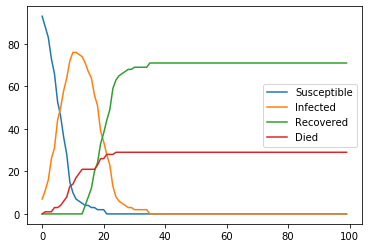

In [845]:
probs_positives = 0.04
grid_limits = [2, 2]
min_contact_radious = 0.3
unlikelyness_of_spread = 0.9
iterations = 100
size = 100
static = False
d_p = 0.02
negatives, positives, survivors, deaths, x_res, y_res, state, index = pop_simulation(size, iterations, 
                                                                                     probs_positives, 
                                                                                     grid_limits, 
                                                                                     min_contact_radious, 
                                                                                     unlikelyness_of_spread, 
                                                                                     static, d_p)
plt.plot(negatives, label='Susceptible')
plt.plot(positives, label='Infected')
plt.plot(survivors, label='Recovered')
plt.plot(deaths, label='Died')
plt.legend()
plt.show()

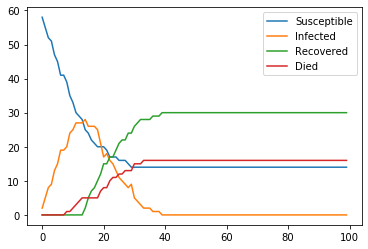

In [855]:
probs_positives = 0.04
grid_limits = [3, 3]
min_contact_radious = 0.3
unlikelyness_of_spread = 0.9
iterations = 100
size = 20
static = False
d_p = 0.02

population = []
for i in range(0, size):
    population.append(Person(np.random.choice(2, 1, p=[1-probs_positives, probs_positives])[0], 
                            [random.uniform(0, grid_limits[0]), random.uniform(0, grid_limits[1])],
                            random.uniform(0, 1), grid_limits))
    
grid_limits2 = [1, 1]
for i in range(0, size):
    population.append(Person(np.random.choice(2, 1, p=[1-probs_positives, probs_positives])[0], 
                            [random.uniform(0, grid_limits2[0]), random.uniform(0, grid_limits2[1])],
                            random.uniform(0, 1), grid_limits2))

grid_limits3 = [3, 3]
for i in range(0, size):
    population.append(Person(np.random.choice(2, 1, p=[1-probs_positives, probs_positives])[0], 
                            [random.uniform(0, grid_limits3[0]), random.uniform(0, grid_limits3[1])],
                            random.uniform(0, 1), grid_limits3))


negatives, positives, survivors = [], [], []
x_res, y_res, state = [], [], []
index, deaths = [], []
for it in range(iterations):
    it_negative, it_positives, it_survivors, it_dead = 0, 0, 0, 0
    for i, single in enumerate(population):
        x_res.append(single.position[0])
        y_res.append(single.position[1])
        index.append(it)
        if single.situation == 0:
            it_negative += 1
            state.append('Susceptible')
        elif single.situation == 1:
            it_positives += 1
            state.append('Infected')
        elif single.situation == 3:
            it_dead += 1
            state.append('Died')
        else:
            it_survivors += 1
            state.append('Recovered')
        single.step_ahead(population[:i]+population[i+1:], min_contact_radious, 
                          unlikelyness_of_spread, no_move=static, deaths_p=d_p)
    negatives.append(it_negative)
    positives.append(it_positives)
    survivors.append(it_survivors)
    deaths.append(it_dead)
    
plt.plot(negatives, label='Susceptible')
plt.plot(positives, label='Infected')
plt.plot(survivors, label='Recovered')
plt.plot(deaths, label='Died')
plt.legend()
plt.show()

In [856]:
negatives[len(negatives)-1], positives[len(negatives)-1], 
survivors[len(negatives)-1], deaths[len(negatives)-1]

(30, 16)

In [787]:
# for i in range(len(negatives)):
#     print(negatives[i] + positives[i] + survivors[i] + deaths[i])

In [857]:
max(positives), max(deaths)

(28, 16)

In [858]:
d = {'x_pos': x_res, 'y_pos': y_res, 'state': state, 'index':index}
df = pd.DataFrame(data=d)
df.head()

,x_pos,y_pos,state,index
0,1.080719,2.531492,Susceptible,0
1,1.620957,2.562754,Susceptible,0
2,1.555464,1.018110,Susceptible,0
3,0.898031,1.286437,Susceptible,0
4,0.876513,1.405502,Susceptible,0


In [859]:
for i in list(df['index'].unique()):
    for j in list(df['state'].unique()):
        if len(df[(df['index']==i) & (df['state'] == j)]) == 0:
            df = df.append(pd.DataFrame([[grid_limits[0]+5, grid_limits[1]+5, j, i]], 
                                        columns=df.columns))

In [860]:
def replay_plot(negatives, positives, survivors, deaths, df):
    fig = make_subplots(rows=2, cols=1)

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
                         mode="lines",
                         line=dict(width=2, color="blue"), name='Susceptible',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=positives,
                         mode="lines",
                         line=dict(width=2, color="green"), name='Infected',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
                         mode="lines",
                         line=dict(width=2, color="orange"), name='Recovered',),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=deaths,
                         mode="lines",
                         line=dict(width=2, color="black"), name='Died',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Susceptible')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Susceptible')]['y_pos'],
        name='Susceptible',
        mode='markers',
        marker=dict(
        color="blue"),
        showlegend=False
        ),
        row=2, col=1)

    fig.add_trace(go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Infected')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Infected')]['y_pos'],
        name='Infected',
        mode='markers',
        marker=dict(
        color="green"),
        showlegend=False
        ),
        row=2, col=1)

    fig.add_trace(go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Recovered')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Recovered')]['y_pos'],
        name='Recovered',
        mode='markers',
        marker=dict(
        color="orange"),
        showlegend=False
        ),
        row=2, col=1)

    frames =[go.Frame(
            data=[go.Scatter(
                x=[i for i in range(k)],
                y=negatives,
                mode="lines",
                line=dict(width=2, color="blue")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=positives,
                mode="lines",
                line=dict(width=2, color="green")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=survivors,
                mode="lines",
                line=dict(width=2, color="orange")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=deaths,
                mode="lines",
                line=dict(width=2, color="black")),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Susceptible')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Susceptible')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="blue")
                    ),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Infected')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Infected')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="green")
                    ),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Recovered')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Recovered')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="orange")
                    ),
                ],
                traces=[0,1,2,3,4,5,6])

            for k in range(len(negatives))] 

    fig.frames=frames
    fig.update_layout(updatemenus= [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 100, "redraw": False},
                                            "fromcurrent": True, 
                                            "transition": {"duration": 10,
                                                           "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.14,
                    "xanchor": "right",
                    "y": 1.4,
                    "yanchor": "top"
                }
            ],)

    fig.update_xaxes(title_text="Simulation Steps", row=1, col=1)
    fig.update_yaxes(title_text="Number of Cases", row=1, col=1)
    fig.update_xaxes(title_text="X", range=[0,grid_limits[0]], row=2, col=1)
    fig.update_yaxes(title_text="Y", range=[0,grid_limits[1]], row=2, col=1)
    fig.update_layout(height=600, width=800, title_text="Interactive Simulation Modelling")
    fig.show()

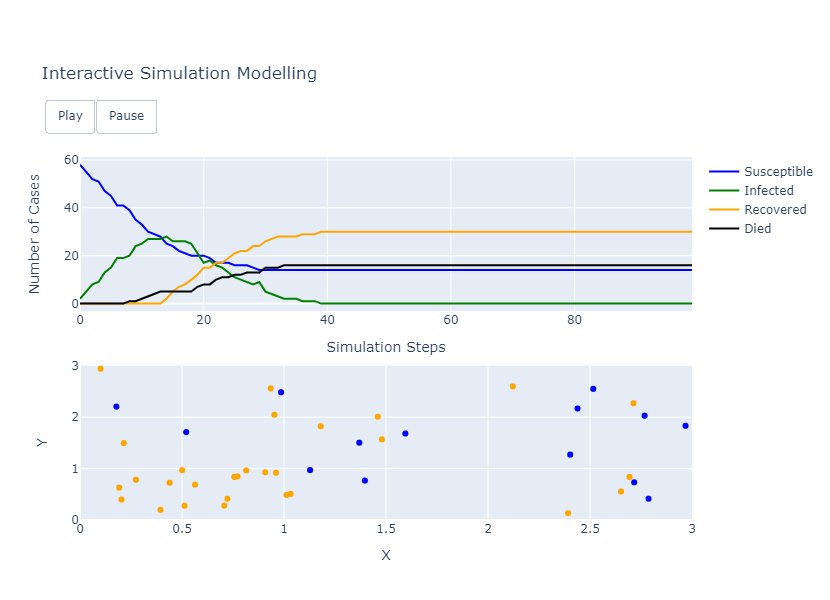

In [861]:
replay_plot(negatives, positives, survivors, deaths, df)

### Extra

In [16]:
# fig = go.FigureWidget()
# fig.add_scatter()
# fig

In [15]:
# for i in range(len(negatives)):
#     #time.sleep(0.3)
#     fig.data[0].y = negatives[:i] 

In [9]:
# import plotly.graph_objects as go

# # Create figure
# fig = go.Figure(
#     data=[go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
#                      mode="lines",
#                      line=dict(width=2, color="blue")),
#           go.Scatter(x=[i for i in range(len(negatives))], y=positives,
#                      mode="lines",
#                      line=dict(width=2, color="green")),
#          go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
#                      mode="lines",
#                      line=dict(width=2, color="orange"))],
#         layout=go.Layout(
#         xaxis=dict(range=[0,100], autorange=False, zeroline=False),
#         yaxis=dict(range=[0,200], autorange=False, zeroline=False),
#         title_text="Kinematic Generation of a Planar Curve", hovermode="closest",
#         updatemenus= [
#             {
#                 "buttons": [
#                     {
#                         "args": [None, {"frame": {"duration": 500, "redraw": False},
#                                         "fromcurrent": True, 
#                                         "transition": {"duration": 300,
#                                                        "easing": "quadratic-in-out"}}],
#                         "label": "Play",
#                         "method": "animate"
#                     },
#                     {
#                         "args": [[None], {"frame": {"duration": 0, "redraw": False},
#                                           "mode": "immediate",
#                                           "transition": {"duration": 0}}],
#                         "label": "Pause",
#                         "method": "animate"
#                     }
#                 ],
#                 "direction": "left",
#                 "pad": {"r": 10, "t": 87},
#                 "showactive": False,
#                 "type": "buttons",
#                 "x": 0.1,
#                 "xanchor": "right",
#                 "y": 0,
#                 "yanchor": "top"
#             }
#         ]),

#     frames=[go.Frame(
#         data=[go.Scatter(
#             x=[i for i in range(k)],
#             y=negatives,
#             mode="lines",
#             line=dict(width=2, color="blue")),
#              go.Scatter(
#             x=[i for i in range(k)],
#             y=positives,
#             mode="lines",
#             line=dict(width=2, color="green")),
#              go.Scatter(
#             x=[i for i in range(k)],
#             y=survivors,
#             mode="lines",
#             line=dict(width=2, color="orange"))])

#         for k in range(len(negatives))],
    
# )

# fig.show()

In [10]:
# index[::-1][0]

In [11]:
# df[(df['index']==0) & (df['state']=='Recovered')]#['x_pos']

In [12]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=df[df['index']==0][df['state']=='Susceptible']['x_pos'], 
#     y=df[df['index']==0][df['state']=='Susceptible']['y_pos'],
#     name='0',
#     mode='markers',
# ))

# fig.add_trace(go.Scatter(
#     x=df[df['index']==0][df['state']=='Infected']['x_pos'], 
#     y=df[df['index']==0][df['state']=='Infected']['y_pos'],
#     name='1',
#     mode='markers',
# ))

# fig.add_trace(go.Scatter(
#     x=df[df['index']==0][df['state']=='Recovered']['x_pos'], 
#     y=df[df['index']==1][df['state']=='Recovered']['x_pos'],
#     name='2',
#     mode='markers',
# ))

# fig.show()

In [13]:
# fig = px.scatter(df, x="x_pos", y="y_pos", color="state", 
#                  animation_frame="index",
#                  range_x=[0,grid_limits[0]], range_y=[0,grid_limits[1]])
# fig

In [14]:
# space = np.linspace(size, size*iterations, iterations)
# for i, num in enumerate(space[1:]):
#     plt.scatter(x_res[int(space[i]):int(num)], y_res[int(space[i]):int(num)], 
#                 c=state[int(space[i]):int(num)])
#     plt.show()

In [15]:
# go.Figure(
#     data=[go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
#                      mode="lines",
#                      line=dict(width=2, color="blue")),
#           go.Scatter(x=[i for i in range(len(negatives))], y=positives,
#                      mode="lines",
#                      line=dict(width=2, color="green")),
#          go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
#                      mode="lines",
#                      line=dict(width=2, color="orange"))],
#         layout=go.Layout(
#         xaxis=dict(range=[0,100], autorange=False, zeroline=False),
#         yaxis=dict(range=[0,200], autorange=False, zeroline=False),
#         title_text="Kinematic Generation of a Planar Curve", hovermode="closest",
#         updatemenus= [
#             {
#                 "buttons": [
#                     {
#                         "args": [None, {"frame": {"duration": 500, "redraw": False},
#                                         "fromcurrent": True, 
#                                         "transition": {"duration": 300,
#                                                        "easing": "quadratic-in-out"}}],
#                         "label": "Play",
#                         "method": "animate"
#                     },
#                     {
#                         "args": [[None], {"frame": {"duration": 0, "redraw": False},
#                                           "mode": "immediate",
#                                           "transition": {"duration": 0}}],
#                         "label": "Pause",
#                         "method": "animate"
#                     }
#                 ],
#                 "direction": "left",
#                 "pad": {"r": 10, "t": 87},
#                 "showactive": False,
#                 "type": "buttons",
#                 "x": 0.1,
#                 "xanchor": "right",
#                 "y": 0,
#                 "yanchor": "top"
#             }
#         ]),

#     frames=[go.Frame(
#         data=[go.Scatter(
#             x=[i for i in range(k)],
#             y=negatives,
#             mode="lines",
#             line=dict(width=2, color="blue")),
#              go.Scatter(
#             x=[i for i in range(k)],
#             y=positives,
#             mode="lines",
#             line=dict(width=2, color="green")),
#              go.Scatter(
#             x=[i for i in range(k)],
#             y=survivors,
#             mode="lines",
#             line=dict(width=2, color="orange"))])

#         for k in range(len(negatives))],
    
# )

In [16]:
# len(negatives), len(df['index'].unique())